### Before run this notebook

Execute following strings in the command line (in the root directory) to install environment and run the server:

```bash
pipenv sync
pipenv run python app.py
```

or these strings to install environment and run the server in Docker container:

```bash
docker build --tag search-face .
docker run -p 8080:8080 search-face
```

The host’s port 8080 will be mapped to the container’s port 8080.

In [1]:
import numpy as np
from PIL import Image, ImageDraw
import requests

# some Jupyter stuff
%load_ext autoreload
%autoreload 2
%load_ext autotime
import autotime
from IPython.display import display, Image as JuImage
autotime.FINISHED_FORMAT = '✔️ {timespan}'

### Let's add two photos

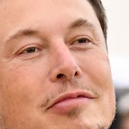

In [2]:
pil_image = Image.open('images/face_1.png')
musk_1 = np.array(pil_image, dtype=np.uint8)
pil_image

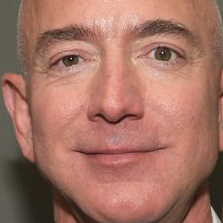

In [3]:
pil_image = Image.open('images/face_2.png')
bezos_1 = np.array(pil_image, dtype=np.uint8)
pil_image

In [4]:
host = '0.0.0.0'
port = 8080
# tolist() is necessary for converting to JSON format
# (just 3-dimentional height-width-channels array)
r = requests.post(f'http://{host}:{port}/add_face_photo',
                  json={'image': musk_1.tolist(), 'name': 'Elon Musk'})
print(r.json())

r = requests.post(f'http://{host}:{port}/add_face_photo',
                  json={'image': bezos_1.tolist(), 'name': 'Jeff Bezos'})
print(r.json())

{'message': 'All right :)', 'success': 1}
{'message': 'All right :)', 'success': 1}


### Let's check who is the nearest

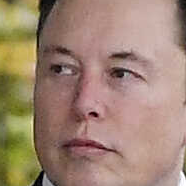

In [5]:
unknown_face = Image.open('images/face_3.png')
musk_2 = np.array(unknown_face, dtype=np.uint8)
unknown_face

In [6]:
r = requests.get(f'http://{host}:{port}/get_nearest',
                 json={'image': musk_2.tolist()})
result = r.json()
print(result.keys())
print(f'Distances: {result["distances"]}')
print(f'Names: {result["names"]}')
print(f'Ids: {result["ids"]}')

dict_keys(['distances', 'ids', 'names', 'success'])
Distances: [0.3879181048893105, 0.8305540618293429]
Names: ['Elon Musk', 'Jeff Bezos']
Ids: [0, 1]


#### Let's look at returned images

dict_keys(['images', 'success'])


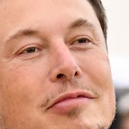

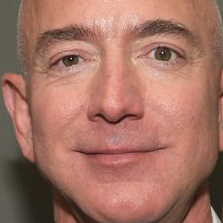

In [7]:
from io import BytesIO

r = requests.get(f'http://{host}:{port}/get_images_by_id',
                 json={'id': result['ids']})
result = r.json()
print(result.keys())
images = []
for list_image in result['images']:
    image = np.array(list_image, dtype=np.uint8)
    images.append(Image.fromarray(image))
for im in images:
    bio = BytesIO()
    im.save(bio, format='png')
    display(JuImage(bio.getvalue(), format='png'))

### Optional, with face_recognition

In [8]:
import face_recognition

image = face_recognition.load_image_file('images/Elon Musk.png')
face_locations = face_recognition.face_locations(image)
# (top, right, bottom, left)
face_locations

[(182, 225, 311, 96), (96, 583, 225, 454)]

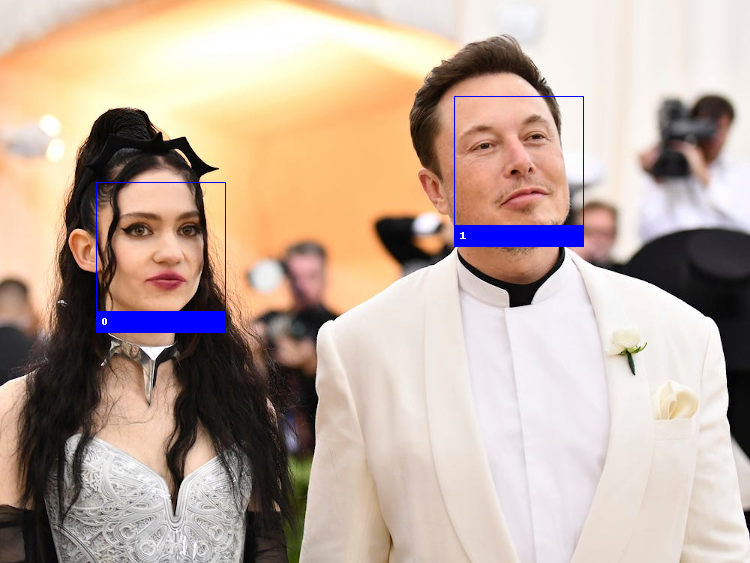

In [9]:
### Optional ###
def draw_boxes(image, face_locations):
    pil_image = Image.fromarray(image)
    draw = ImageDraw.Draw(pil_image)

    for name, (top, right, bottom, left) in enumerate(face_locations):
        name = str(name)
        draw.rectangle(((left, top), (right, bottom)), outline=(0, 0, 255))
        text_width, text_height = draw.textsize(name)
        draw.rectangle(((left, bottom), (right, bottom + text_height + 10)),
                       fill=(0, 0, 255), outline=(0, 0, 255))
        draw.text((left + 6, bottom + 5), name, fill=(255, 255, 255, 255))

    del draw

    display(pil_image)
draw_boxes(image, face_locations)

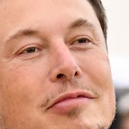

In [10]:
top, right, bottom, left = face_locations[1]
musk_1 = image[top:bottom, left:right]
face = Image.fromarray(musk_1)
face

In [11]:
image = face_recognition.load_image_file('images/Jeff Bezos.jpeg')
face_locations = face_recognition.face_locations(image)
face_locations

[(118, 712, 341, 489)]

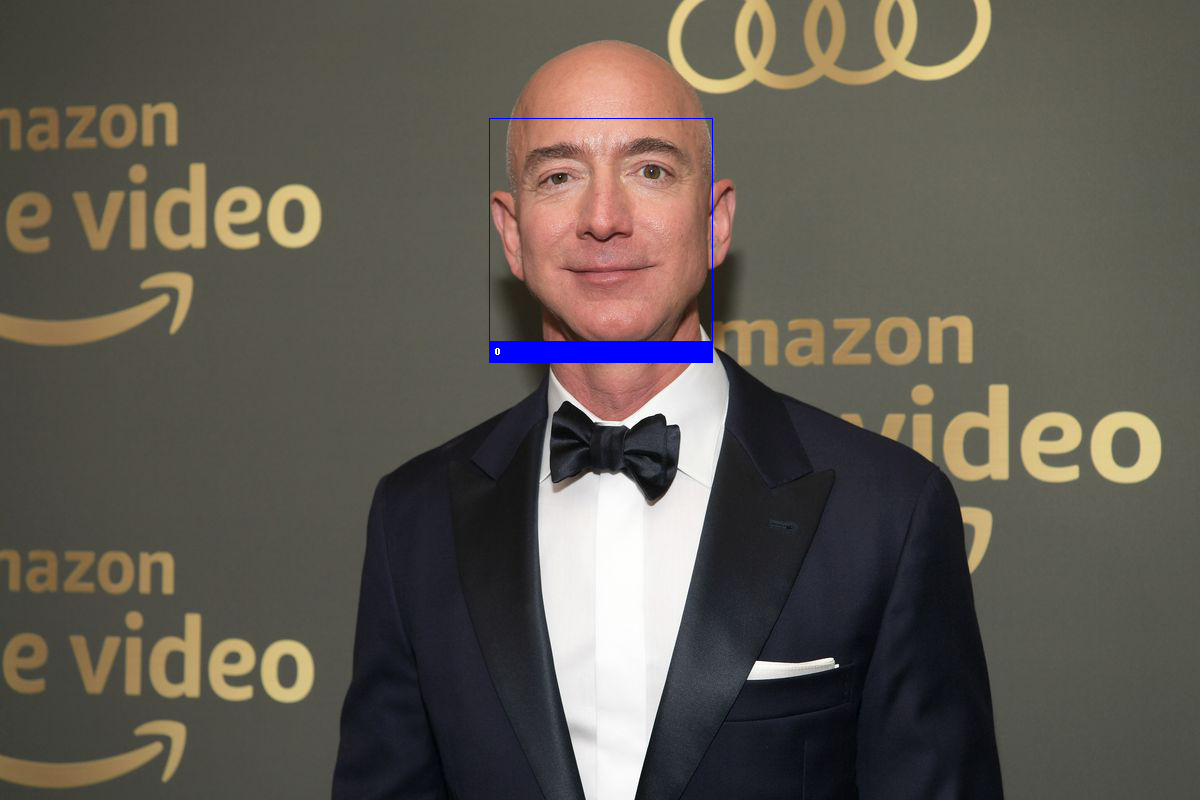

In [12]:
draw_boxes(image, face_locations)

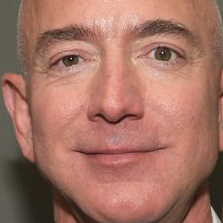

In [13]:
top, right, bottom, left = face_locations[0]
bezos_1 = image[top:bottom, left:right]
face = Image.fromarray(bezos_1)
face

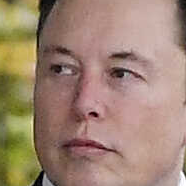

In [14]:
unknown_image = face_recognition.load_image_file('images/unknown.jpg')
face_locations = face_recognition.face_locations(unknown_image)
top, right, bottom, left = face_locations[2]
musk_2 = unknown_image[top:bottom, left:right]
face = Image.fromarray(musk_2)
face

In [15]:
# check nearest again
r = requests.get(f'http://0.0.0.0:{port}/get_nearest',
                 json={'image': musk_2.tolist()})
result = r.json()
print(f'Distances: {result["distances"]}')
print(f'Names: {result["names"]}')
print(f'Ids: {result["ids"]}')

Distances: [0.3879181048893105, 0.8305540618293429]
Names: ['Elon Musk', 'Jeff Bezos']
Ids: [0, 1]
